# 代码生成

## AlphaCodium 和流程工程

最近的工作，例如 AlphaCodium，已经表明代码生成可以[通过使用“流”范式得到显着改进](https://x.com/karpathy/status/1748043513156272416?s=20)。

“流程”范式不是简单的“提示：回答”范式，而是迭代地构造编码问题的答案。

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) 针对特定问题迭代测试并改进公共测试和人工智能生成的测试的答案。

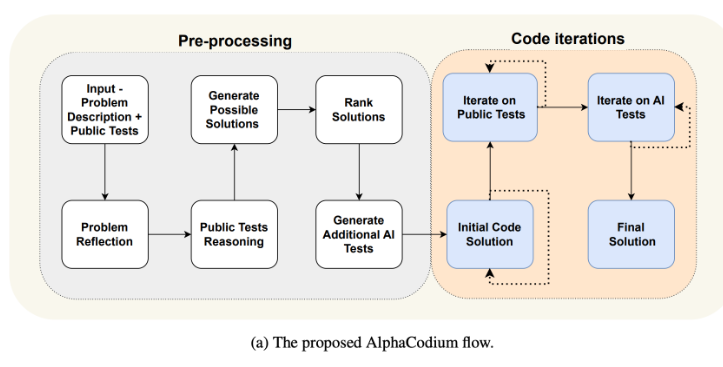
---

## LangGraph自纠码助手

我们想要测试 LangGraph 中迭代代码生成的总体思路，并对 AlphaCodium 工作进行一些简化：

1. 我们从用户指定的一组文档开始
2.我们使用长上下文LLM来摄取它，并根据它回答问题
3. 我们执行两层检查：我们检查导入以查看是否引入了幻觉
4. 我们检查代码执行以确定代码是否能够无错误地执行

检查有效的导入和执行是针对与代码库相关的开放式问题进行代码测试的合理起点。

![image.png](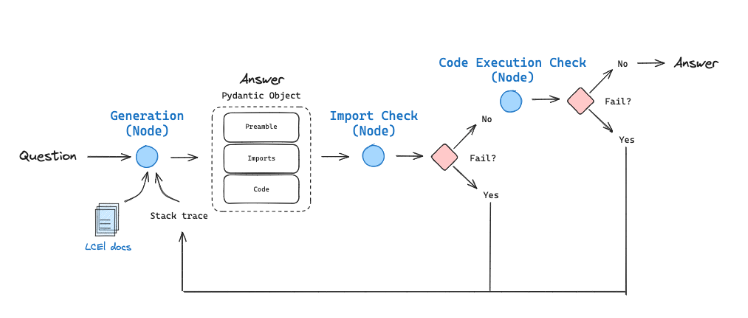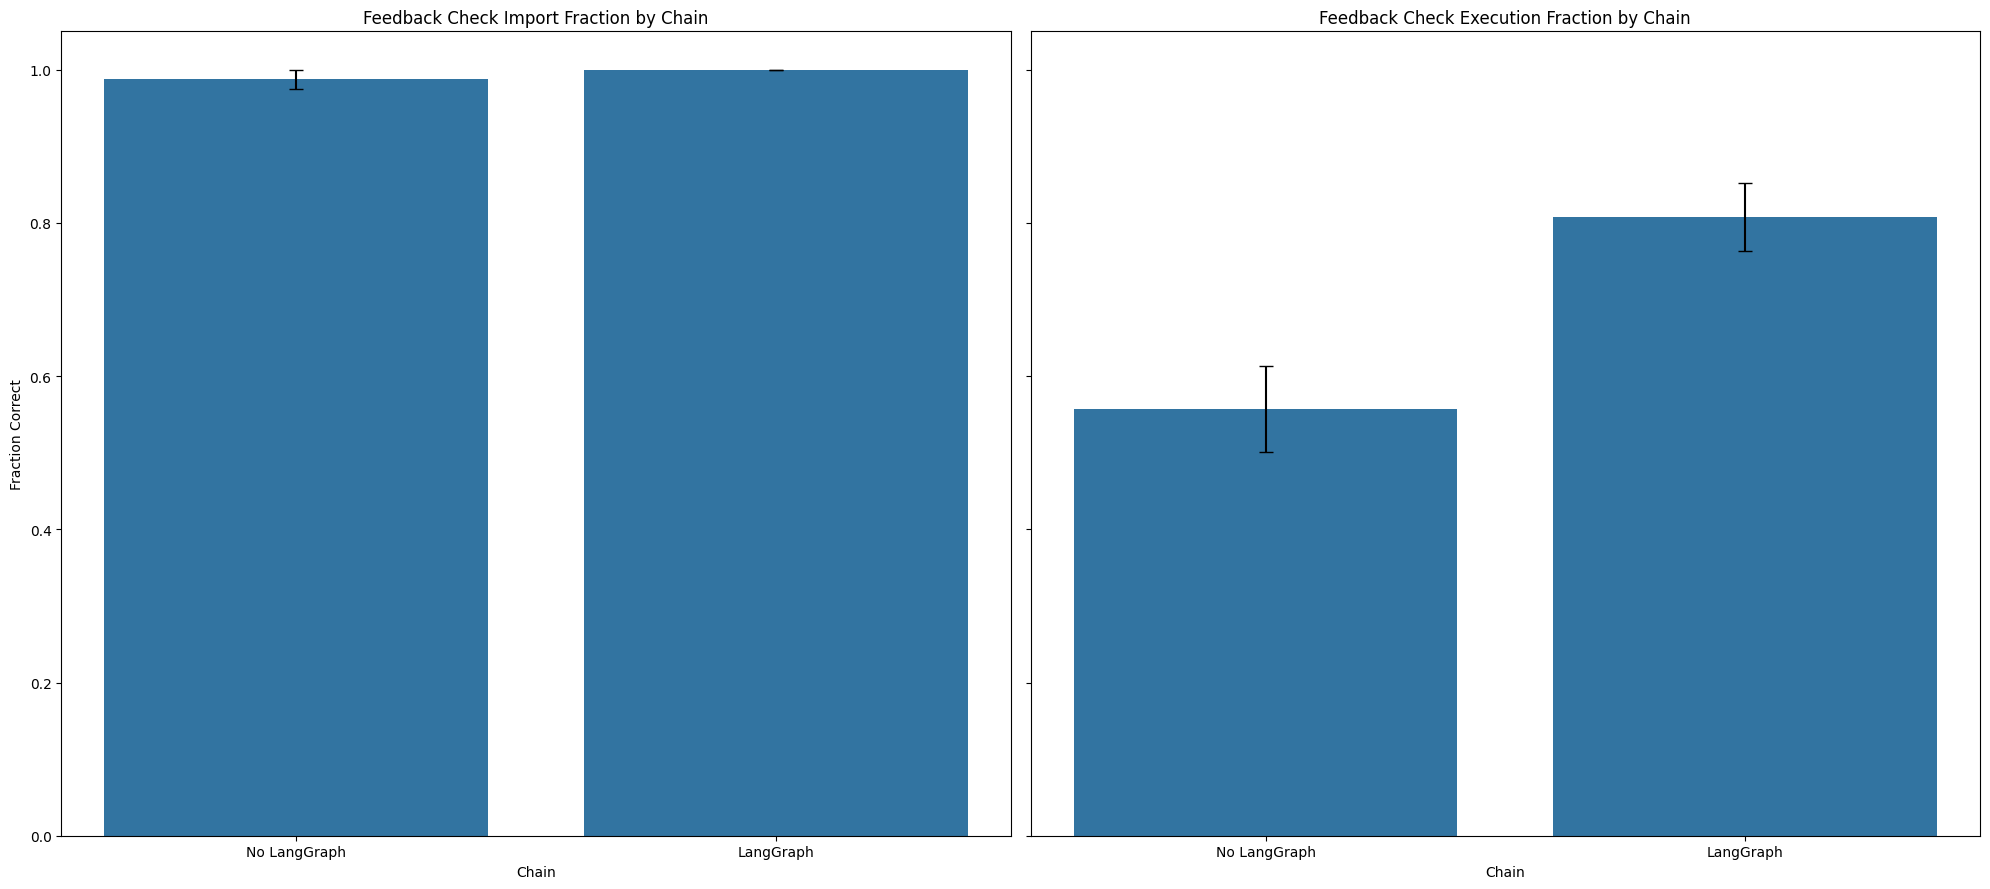)

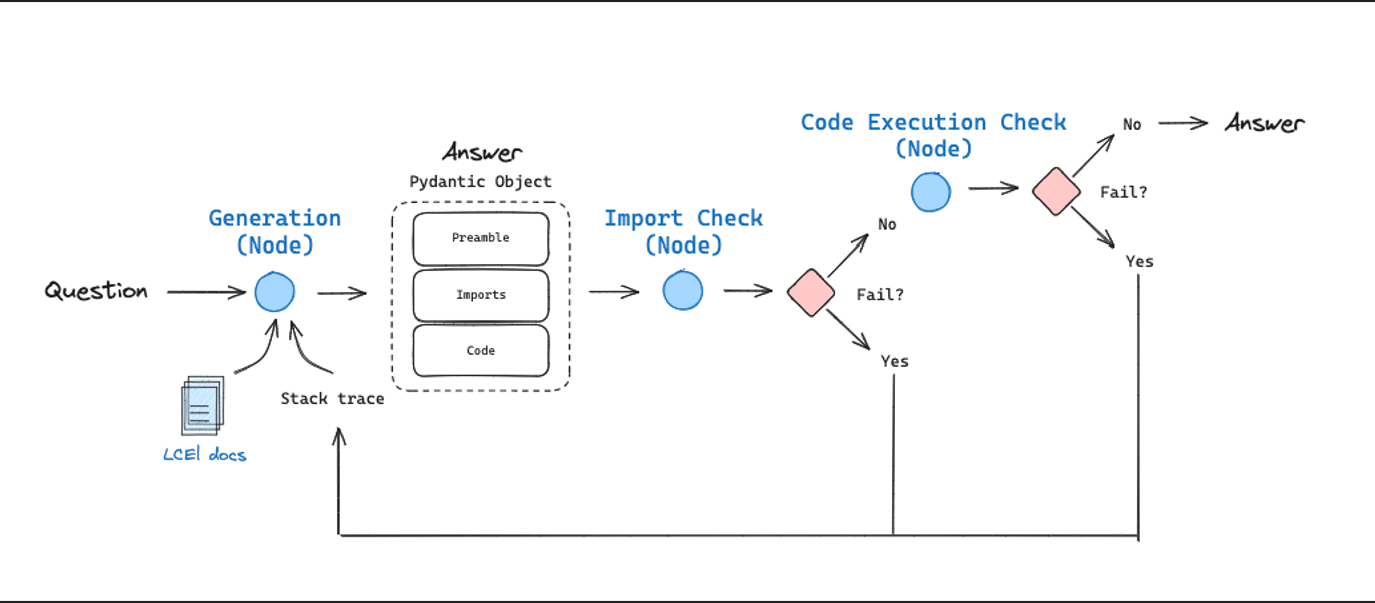

In [1]:
%%capture --no-stderr
%pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph faiss-cpu

In [17]:
%pip install langsmith

## 文档

作为测试用例，让我们加载与 [LangChain 表达式语言](https://python.langchain.com/docs/expression_language/) (LCEL) 相关的文档。

In [2]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL 文档
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser （在主要 LCEL 文档之外）
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ 自查询（在主要 LCEL 文档之外）
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# 添加
docs.extend([*docs_pydantic, *docs_sq])

# 根据“元数据”->“源”中的 URL 对列表进行排序
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 连接每个排序字典的“page_content”
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [3]:
concatenated_content

'\n\n\n\n\nQuickstart | 🦜️🔗 Langchain\n\n\n\n\n\n\n\nSkip to main contentDocsUse casesIntegrationsGuidesAPIMorePeopleVersioningChangelogContributingTemplatesCookbooksTutorialsYouTube🦜️🔗LangSmithLangSmith DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS Docs💬SearchGet startedIntroductionInstallationQuickstartSecurityLangChain Expression LanguageGet startedWhy use LCELInterfaceStreamingHow toCookbookLangChain Expression Language (LCEL)ModulesModel I/OModel I/OQuickstartConceptsPromptsChat ModelsLLMsOutput ParsersQuickstartCustom Output ParsersTypesRetrievalAgentsChainsMoreLangServeLangSmithLangGraphModulesModel I/OOutput ParsersQuickstartOn this pageQuickstartLanguage models output text. But many times you may want to get more\nstructured information than just text back. This is where output parsers\ncome in.Output parsers are classes that help structure language model responses.\nThere are two main methods an output parser must implement:“Get format instructions”: A m

In [11]:
from google.colab import userdata
OPENAI_API_KEY= userdata.get('OPENAI_API_KEY')

import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "LangGraph code assistant"

＃＃＃ 基本情况

这是没有 LangGraph 的上下文填充。

In [12]:
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI

## Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


## LLM
model = ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY, model="gpt-4-0125-preview", streaming=True)

# Tool
code_tool_oai = convert_to_openai_tool(code)

# 具有工具和强制调用的LLM
llm_with_tool = model.bind(
    tools=[convert_to_openai_tool(code_tool_oai)],
    tool_choice={"type": "function", "function": {"name": "code"}},
)

# 解析
parser_tool = PydanticToolsParser(tools=[code])

# 创建包含格式说明和查询的提示模板
prompt = PromptTemplate(
    template="""You are a coding assistant with expertise in LCEL, LangChain expression language. \n
        Here is a full set of LCEL documentation:
        \n ------- \n
        {context}
        \n ------- \n
        Answer the user question based on the above provided documentation. \n
        Ensure any code you provide can be executed with all required imports and variables defined. \n
        Structure your answer with a description of the code solution. \n
        Then list the imports. And finally list the functioning code block. \n
        Here is the user question: \n --- --- --- \n {question}""",
    input_variables=["question", "context"],
)


def parse_answer_to_dict(x):
    return x[0].dict()


chain_base_case = (
    {
        "context": lambda _: concatenated_content,
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm_with_tool
    | parser_tool
    | RunnableLambda(parse_answer_to_dict)
)

In [37]:
answer_with_nograph = chain_base_case.invoke("How to Visualize Flow of Chain as Graph using LCEL")
answer_with_nograph

{'prefix': "To visualize the flow of a chain as a graph using LangChain Expression Language (LCEL), you can utilize the `get_graph` method available on any chain. This method returns a graph representation of the chain, which can be visualized using various graph visualization libraries such as Graphviz. Here's a step-by-step guide on how to achieve this:\n\n",
 'imports': 'from langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser\nimport graphviz\n',
 'code': '# Define the components of the chain\nprompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")\nmodel = ChatOpenAI()\noutput_parser = StrOutputParser()\n\n# Compose the chain\nchain = prompt | model | output_parser\n\n# Get the graph representation of the chain\nchain_graph = chain.get_graph()\n\n# Visualize the graph using Graphviz\ndot = graphviz.Source(chain_graph.to_dot())\ndot.render(\'chain_graph\', format=\'png

In [38]:
answer_with_nograph['prefix']

"To visualize the flow of a chain as a graph using LangChain Expression Language (LCEL), you can utilize the `get_graph` method available on any chain. This method returns a graph representation of the chain, which can be visualized using various graph visualization libraries such as Graphviz. Here's a step-by-step guide on how to achieve this:\n\n"

In [39]:
answer_with_nograph['imports']

'from langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser\nimport graphviz\n'

In [40]:
exec(answer_with_nograph['imports'])

In [41]:
answer_with_nograph['code']

'# Define the components of the chain\nprompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")\nmodel = ChatOpenAI()\noutput_parser = StrOutputParser()\n\n# Compose the chain\nchain = prompt | model | output_parser\n\n# Get the graph representation of the chain\nchain_graph = chain.get_graph()\n\n# Visualize the graph using Graphviz\ndot = graphviz.Source(chain_graph.to_dot())\ndot.render(\'chain_graph\', format=\'png\', cleanup=True)\n\n# This will generate a PNG image named \'chain_graph.png\' visualizing the chain flow.'

In [42]:
exec(answer_with_nograph['code'])

AttributeError: 'Graph' object has no attribute 'to_dot'

＃＃ 状态

我们的状态是一个字典，其中包含与代码生成相关的键（错误、问题、代码生成）。

In [14]:
from typing import Dict, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

## 图

我们的图表展示了上图所示的逻辑流程。

In [15]:
from operator import itemgetter

from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI


def generate(state: GraphState):
    """
     根据 LCEL 文档和输入问题生成代码解决方案
     带有来自代码执行测试的可选反馈

     参数：
         state (dict): 当前图状态

     返回：
         state (dict)：添加到包含检索到的文档的状态、文档的新键
    """

    ## 状态
    state_dict = state["keys"]
    question = state_dict["question"]
    iter = state_dict["iterations"]

    ## Data model
    class code(BaseModel):
        """Code output"""

        prefix: str = Field(description="Description of the problem and approach")
        imports: str = Field(description="Code block import statements")
        code: str = Field(description="Code block not including import statements")

    ## LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    code_tool_oai = convert_to_openai_tool(code)

    # 具有工具和强制调用的LLM
    llm_with_tool = model.bind(
        tools=[code_tool_oai],
        tool_choice={"type": "function", "function": {"name": "code"}},
    )

    # 解析器
    parser_tool = PydanticToolsParser(tools=[code])

    ## Prompt
    template = """You are a coding assistant with expertise in LCEL, LangChain expression language. \n
        Here is a full set of LCEL documentation:
        \n ------- \n
        {context}
        \n ------- \n
        Answer the user question based on the above provided documentation. \n
        Ensure any code you provide can be executed with all required imports and variables defined. \n
        Structure your answer with a description of the code solution. \n
        Then list the imports. And finally list the functioning code block. \n
        Here is the user question: \n --- --- --- \n {question}"""

    ## 生成
    if "error" in state_dict:
        print("---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---")

        error = state_dict["error"]
        code_solution = state_dict["generation"]

        # 更新 prompt
        addendum = """  \n --- --- --- \n You previously tried to solve this problem. \n Here is your solution:
                    \n --- --- --- \n {generation}  \n --- --- --- \n  Here is the resulting error from code
                    execution:  \n --- --- --- \n {error}  \n --- --- --- \n Please re-try to answer this.
                    Structure your answer with a description of the code solution. \n Then list the imports.
                    And finally list the functioning code block. Structure your answer with a description of
                    the code solution. \n Then list the imports. And finally list the functioning code block.
                    \n Here is the user question: \n --- --- --- \n {question}"""
        template = template + addendum

        # Prompt
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question", "generation", "error"],
        )

        # Chain
        chain = (
            {
                "context": lambda _: concatenated_content,
                "question": itemgetter("question"),
                "generation": itemgetter("generation"),
                "error": itemgetter("error"),
            }
            | prompt
            | llm_with_tool
            | parser_tool
        )

        code_solution = chain.invoke(
            {"question": question, "generation": str(code_solution[0]), "error": error}
        )

    else:
        print("---GENERATE SOLUTION---")

        # Prompt
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        )

        # Chain
        chain = (
            {
                "context": lambda _: concatenated_content,
                "question": itemgetter("question"),
            }
            | prompt
            | llm_with_tool
            | parser_tool
        )

        code_solution = chain.invoke({"question": question})

    iter = iter + 1
    return {
        "keys": {"generation": code_solution, "question": question, "iterations": iter}
    }


def check_code_imports(state: GraphState):
    """
     检查import

     参数：
         state (dict): 当前图状态

     返回：
         state (dict)：添加到状态的新键，错误
    """

    ## 状态
    print("---CHECKING CODE IMPORTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    imports = code_solution[0].imports
    iter = state_dict["iterations"]

    try:
        # 尝试执行 imports
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        # 捕获执行期间的任何错误（例如 ImportError、SyntaxError）
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error
    else:
        print("---CODE IMPORT CHECK: SUCCESS---")
        # 没有发生错误
        error = "None"

    return {
        "keys": {
            "generation": code_solution,
            "question": question,
            "error": error,
            "iterations": iter,
        }
    }


def check_code_execution(state: GraphState):
    """
     检查代码块执行情况

     参数：
         state (dict): 当前图状态

     返回：
         state (dict)：添加到状态的新键，错误
    """

    ## 状态
    print("---CHECKING CODE EXECUTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    prefix = code_solution[0].prefix
    imports = code_solution[0].imports
    code = code_solution[0].code
    code_block = imports + "\n" + code
    iter = state_dict["iterations"]

    try:
        # 尝试执行代码块
        exec(code_block)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        # 捕获执行期间的任何错误（例如 ImportError、SyntaxError）
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error
    else:
        print("---CODE BLOCK CHECK: SUCCESS---")
        # 没有发生错误
        error = "None"

    return {
        "keys": {
            "generation": code_solution,
            "question": question,
            "error": error,
            "prefix": prefix,
            "imports": imports,
            "iterations": iter,
            "code": code,
        }
    }


### 边


def decide_to_check_code_exec(state: GraphState):
    """
     确定是否测试代码执行，或重试答案生成。

     参数：
        state (dict): 当前图状态

     返回：
         str：下一个要调用的节点
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]

    if error == "None":
        # 所有文档均已过滤 check_relevance
        # 我们将重新生成一个新的查询
        print("---DECISION: TEST CODE EXECUTION---")
        return "check_code_execution"
    else:
        # 我们有相关文件，因此生成答案
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


def decide_to_finish(state: GraphState):
    """
     确定是否完成（重试代码 3 次。

     参数：
         state (dict): 当前图状态

     返回：
         str：下一个要调用的节点
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]
    iter = state_dict["iterations"]

    if error == "None" or iter == 3:
        # 所有文档均已过滤 check_relevance
        # 我们将重新生成一个新的查询
        print("---DECISION: TEST CODE EXECUTION---")
        return "end"
    else:
        # 我们有相关文件，因此生成答案
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

In [16]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# 定义节点
workflow.add_node("generate", generate)  # 生成节点
workflow.add_node("check_code_imports", check_code_imports)  # 检查 imports
workflow.add_node("check_code_execution", check_code_execution)  # 检查代码 execution

# 建立图
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code_imports")
workflow.add_conditional_edges(
    "check_code_imports",
    decide_to_check_code_exec,
    {
        "check_code_execution": "check_code_execution",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "check_code_execution",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

# 整合
app = workflow.compile()

In [18]:
question = "I am passing test key 'foo' to my prompt and want to process it with a function, process_text(...), prior to the prompt. How can I do this with LCEL"
config = {"recursion_limit": 50}
answer = app.invoke({"keys":{"question":question, "iterations": 0}},config=config)

---GENERATE SOLUTION---


---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---


---DECIDE TO TEST CODE EXECUTION---
---DECISION: RE-TRY SOLUTION---
---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---


---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---


content='Hello! How can I assist you with your TEST today?' response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 13, 'total_tokens': 25}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_4f0b692a78', 'finish_reason': 'stop', 'logprobs': None}
---CODE BLOCK CHECK: SUCCESS---
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---


In [19]:
answer

{'keys': {'generation': [code(prefix="To process a key before passing it to a prompt in LCEL, you can use a `RunnableLambda` to define a custom function that processes the input. This function can then be chained before the prompt to ensure the processed input is used. Here's how you can achieve this:\n\n", imports="from langchain_core.runnables import RunnableLambda\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\n\n# Define your custom processing function\ndef process_text(input_dict: dict) -> dict:\n    # Example processing, replace this with your actual processing logic\n    input_dict['foo'] = input_dict['foo'].upper()\n    return input_dict\n\n", code='# Create a RunnableLambda with your processing function\nprocess_text_runnable = RunnableLambda(process_text)\n\n# Define your prompt template\nprompt = ChatPromptTemplate.from_template("Your processed input is: {foo}")\n\n# Define your model\nmodel = ChatOpenAI()\n\n# Chain the compo

In [21]:
answer['keys']['generation'][0].prefix

"To process a key before passing it to a prompt in LCEL, you can use a `RunnableLambda` to define a custom function that processes the input. This function can then be chained before the prompt to ensure the processed input is used. Here's how you can achieve this:\n\n"

In [24]:
answer['keys']['generation'][0].imports

"from langchain_core.runnables import RunnableLambda\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\n\n# Define your custom processing function\ndef process_text(input_dict: dict) -> dict:\n    # Example processing, replace this with your actual processing logic\n    input_dict['foo'] = input_dict['foo'].upper()\n    return input_dict\n\n"

In [23]:
exec(answer['keys']['generation'][0].imports)

In [25]:
answer['keys']['generation'][0].code

'# Create a RunnableLambda with your processing function\nprocess_text_runnable = RunnableLambda(process_text)\n\n# Define your prompt template\nprompt = ChatPromptTemplate.from_template("Your processed input is: {foo}")\n\n# Define your model\nmodel = ChatOpenAI()\n\n# Chain the components\ncustom_chain = process_text_runnable | prompt | model\n\n# Example invocation\nresult = custom_chain.invoke({\'foo\': \'test\'})\nprint(result)'

In [27]:
exec(answer['keys']['generation'][0].code)

content='Hello! How can I assist you with your test?' response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_4f0b692a78', 'finish_reason': 'stop', 'logprobs': None}


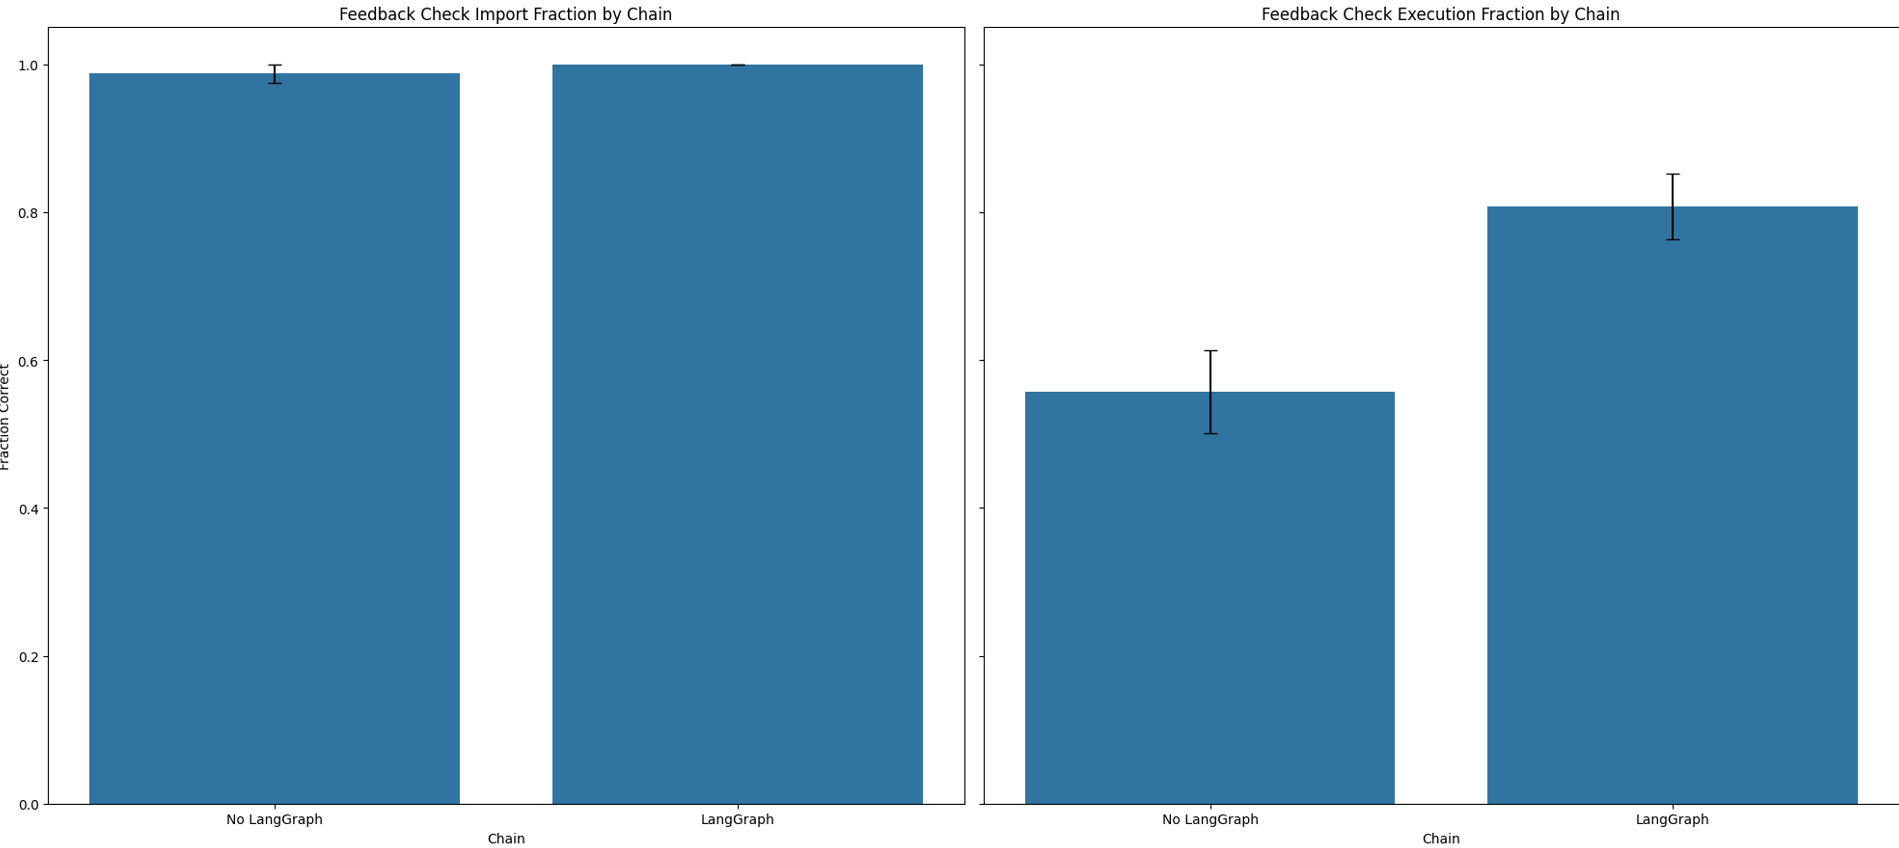